# Objective

1. Data preparation and engineering
2. Introduction to geospatial visualization library Folium
3. Preliminary analysis on the dataset

# Import data

*Required dependencies*

- pandas
- pyarrow / fastparquet
- folium
- branca (with folium)


In [ ]:
# mount drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Jakarta.zip"

Archive:  /content/drive/MyDrive/Grab-Posisi dataset/grab-posis-city=Jakarta.zip
   creating: city=Jakarta/
  inflating: city=Jakarta/part-00003-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00008-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00004-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00005-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00002-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00009-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00007-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/part-00001-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet  
  inflating: city=Jakarta/pa

# Data preparation and engineering

In [ ]:
import pandas as pd
import datetime

In [ ]:
df = pd.read_parquet("/content/city=Jakarta/part-00000-8bbff892-97d2-4011-9961-703e38972569.c000.snappy.parquet", engine = 'pyarrow')
df

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
0,4820,car,android,1554806010,-6.591032,106.834468,20.425203,194,4.000
1,46324,car,android,1554873765,-6.247526,106.977663,4.220000,101,10.720
2,15007,car,android,1555642661,-6.267404,107.036016,1.990000,108,3.149
3,4239,motorcycle,ios,1554859883,-6.293342,106.820029,1.010000,288,10.000
4,83096,motorcycle,ios,1554815699,-6.146359,106.871882,11.000000,14,10.000
...,...,...,...,...,...,...,...,...,...
5597257,55124,motorcycle,ios,1555860173,-6.224690,106.639591,6.630000,226,5.000
5597258,65951,car,android,1555732048,-6.141392,106.820090,6.750000,13,21.238
5597259,47190,car,android,1555832320,-6.188814,106.875438,20.930000,181,3.900
5597260,74731,car,ios,1555655508,-6.324032,106.834404,11.460000,35,10.000


Note that pingtimestamp is unix time, meaning that it is the number of seconds from 1 Jan 1970

In [ ]:
# show full summary of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597262 entries, 0 to 5597261
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   trj_id         object 
 1   driving_mode   object 
 2   osname         object 
 3   pingtimestamp  int64  
 4   rawlat         float64
 5   rawlng         float64
 6   speed          float64
 7   bearing        int64  
 8   accuracy       float64
dtypes: float64(4), int64(2), object(3)
memory usage: 384.3+ MB


In [ ]:
# functions to change dtypes
def to_category(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("category")
    
def to_float32(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("float32")
        
def to_uint16(df, *args):
    for col_name in args:
        df[col_name] = df[col_name].astype("uint16")
  
def to_int32(df, *args):
    for col_name in args:
      df[col_name] = df[col_name].astype("int32")

def format_datetime(df, col_name):
    # get datetime obj for all timestamps
    dt = df[col_name].apply(datetime.datetime.fromtimestamp)
    
    df["time"] = dt.apply(lambda x: x.time())
    df["day_of_week"] = dt.apply(lambda x: x.weekday())
    df["month"] = dt.apply(lambda x: x.month)
    df["year"] = dt.apply(lambda x: x.year)

In [ ]:
# get a copy of the df
df_formatted = df.copy()

In [ ]:
# format all columns
format_datetime(df_formatted, "pingtimestamp")
to_category(df_formatted, ["trj_id", "driving_mode", "osname"])
to_float32(df_formatted, ["rawlat", "rawlng", "speed", "accuracy"])
to_uint16(df_formatted, ["bearing", "day_of_week", "month", "year"])
to_int32(df_formatted, "pingtimestamp")

In [ ]:
# check summary of df again
df_formatted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597262 entries, 0 to 5597261
Data columns (total 13 columns):
 #   Column         Dtype   
---  ------         -----   
 0   trj_id         category
 1   driving_mode   category
 2   osname         category
 3   pingtimestamp  int32   
 4   rawlat         float32 
 5   rawlng         float32 
 6   speed          float32 
 7   bearing        uint16  
 8   accuracy       float32 
 9   time           object  
 10  day_of_week    uint16  
 11  month          uint16  
 12  year           uint16  
dtypes: category(3), float32(4), int32(1), object(1), uint16(4)
memory usage: 226.6+ MB


In [ ]:
df_formatted.describe(include = "all")

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,month,year
count,5597262,5597262,5597262,5.597262e+06,5.597262e+06,5.597262e+06,5.597262e+06,5.597262e+06,5.597262e+06,5597262,5.597262e+06,5597262.0,5597262.0
unique,55995,2,2,NaN,NaN,NaN,NaN,NaN,NaN,85894,NaN,NaN,NaN
top,16886,car,android,NaN,NaN,NaN,NaN,NaN,NaN,10:22:01,NaN,NaN,NaN
freq,1969,3017114,3874009,NaN,NaN,NaN,NaN,NaN,NaN,179,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.555361e+09,-6.092810e+00,1.035026e+02,7.740098e+00,1.712885e+02,6.370943e+00,NaN,3.311260e+00,4.0,2019.0
std,NaN,NaN,NaN,3.634501e+05,1.948299e-01,3.370651e+00,5.149222e+00,1.086143e+02,4.693223e+00,NaN,1.961863e+00,0.0,0.0
min,NaN,NaN,NaN,1.554682e+09,-6.878480e+00,1.058844e+02,-1.000000e+00,0.000000e+00,1.000000e-02,NaN,0.000000e+00,4.0,2019.0
25%,NaN,NaN,NaN,1.555044e+09,-6.296432e+00,1.067698e+02,4.017921e+00,8.300000e+01,3.900000e+00,NaN,2.000000e+00,4.0,2019.0
50%,NaN,NaN,NaN,1.555412e+09,-6.235270e+00,1.068222e+02,7.304307e+00,1.740000e+02,5.000000e+00,NaN,3.000000e+00,4.0,2019.0
75%,NaN,NaN,NaN,1.555674e+09,-6.186346e+00,1.068779e+02,1.049000e+01,2.680000e+02,8.405000e+00,NaN,5.000000e+00,4.0,2019.0


In [ ]:
import folium
from folium import plugins
from branca.element import Figure

# latitude and longitude of Singapore
sg_lat = 1.290270
sg_lng = 103.851959

# Exploratory data analysis



**Problem statement**

There has been feedback about <b><font color='red'>delays</font></b> in Grab transport services in both Jakarta and Singapore (late driver arrival -> late arrival at destination). This has led to a decrease in customer satisfaction and trust, which might increase customer turnover. Upon further research, it was found that this could be due to inaccurate ETA prediction, bad route planning, or other factors. Using the above dataset of GPS pings, what insights can your team obtain to help Grab alleviate these issues? 

---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_formatted

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,month,year
0,4820,car,android,1554806010,-6.591033,106.834465,20.425203,194,4.000000,10:33:30,1,4,2019
1,46324,car,android,1554873765,-6.247526,106.977661,4.220000,101,10.720000,05:22:45,2,4,2019
2,15007,car,android,1555642661,-6.267404,107.036018,1.990000,108,3.149000,02:57:41,4,4,2019
3,4239,motorcycle,ios,1554859883,-6.293343,106.820030,1.010000,288,10.000000,01:31:23,2,4,2019
4,83096,motorcycle,ios,1554815699,-6.146359,106.871880,11.000000,14,10.000000,13:14:59,1,4,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597257,55124,motorcycle,ios,1555860173,-6.224690,106.639587,6.630000,226,5.000000,15:22:53,6,4,2019
5597258,65951,car,android,1555732048,-6.141392,106.820091,6.750000,13,21.238001,03:47:28,5,4,2019
5597259,47190,car,android,1555832320,-6.188814,106.875435,20.930000,181,3.900000,07:38:40,6,4,2019
5597260,74731,car,ios,1555655508,-6.324032,106.834404,11.460000,35,10.000000,06:31:48,4,4,2019


In [ ]:
df_formatted['trj_id'].nunique()

55995

In [ ]:
df_formatted['trj_id'].value_counts()

16886    1969
10484    1469
40947    1202
39208    1119
30585    1043
         ... 
51164       5
14703       4
51187       1
82062       1
43760       1
Name: trj_id, Length: 55995, dtype: int64

Distribution of os

Different os might have different accuracy/bugs

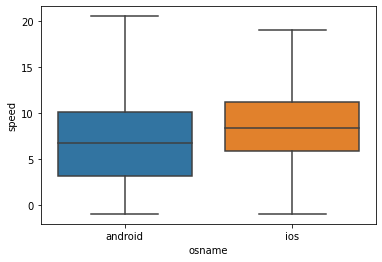

In [ ]:
sns.boxplot(data = df_formatted, x = 'osname', y = 'speed', showfliers = False)

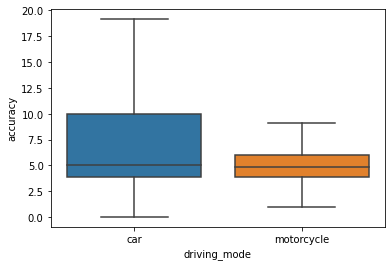

In [ ]:
sns.boxplot(data = df_formatted, x = 'driving_mode', y = 'accuracy', showfliers = False)

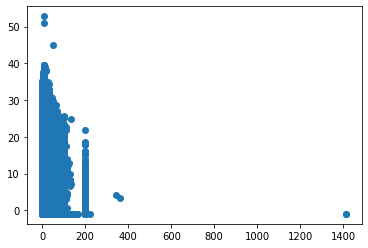

In [ ]:
plt.scatter(data = df_formatted, x = 'accuracy', y = 'speed')

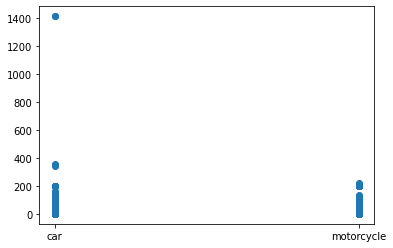

In [ ]:
plt.scatter(data = df_formatted, x = 'driving_mode', y = 'accuracy')

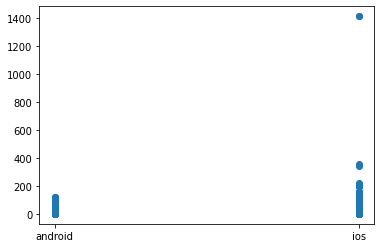

In [ ]:
plt.scatter(data = df_formatted, x = 'osname', y = 'accuracy')

ios results in higher inaccuracies of the tracking, resulting in higher delays.

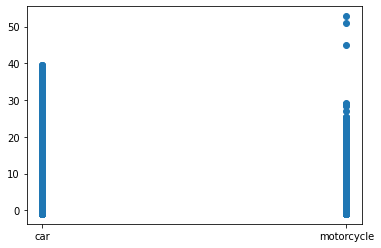

In [ ]:
plt.scatter( df_formatted['driving_mode'], df_formatted['speed'] )

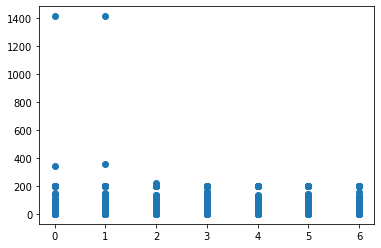

In [ ]:
plt.scatter( df_formatted['day_of_week'], df_formatted['accuracy'] )

sunday has lowest level of inaccuracies due to low level of traffic

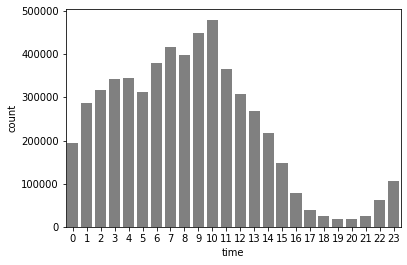

In [ ]:
hours = df_formatted['time'].apply(lambda x: x.hour)
sns.countplot(x = hours, color = 'grey')

In [ ]:
df_formatted['time']

0          00:40:36
1          10:17:03
2          07:37:06
3          03:41:33
4          10:48:17
             ...   
3034548    08:27:17
3034549    13:25:52
3034550    00:15:14
3034551    14:58:11
3034552    23:28:51
Name: time, Length: 3034553, dtype: object

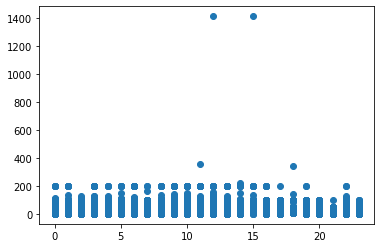

In [ ]:
plt.scatter(hours, df_formatted['accuracy'])

at noon time (7am - 3pm), there is higher inaccuracy observed 

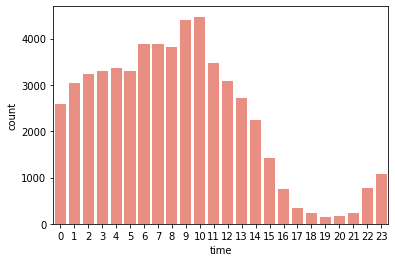

In [ ]:
initial_pings = df_formatted.groupby('trj_id')['time'].min()
initial_pings_hours = initial_pings.apply(lambda x: x.hour)
sns.countplot(x = initial_pings_hours, color = 'salmon')

In [ ]:
peak_period = df_formatted[(hours == 9) | (hours == 10) | (hours == 11) ]

NameError: ignored

In [ ]:
pings = peak_period[['rawlat', 'rawlng']].to_numpy()

In [ ]:
pings

array([[  1.3217812, 103.85637  ],
       [  1.283799 , 103.80721  ],
       [  1.3259093, 103.83332  ],
       ...,
       [  1.395916 , 103.84025  ],
       [  1.4008759, 103.81266  ],
       [  1.3269511, 103.7253   ]], dtype=float32)

In [ ]:
# get mean speed of each trajectory
mean_speed = peak_period.groupby('trj_id')['speed'].agg(mean_speed = ('mean'))


# extract trajectories with valid mean speed
mean_speed = mean_speed[mean_speed['mean_speed'].notnull()]

# sort by mean_speed
mean_speed.sort_values('mean_speed', inplace = True)

# retrieve slowest 3 trajectories 
slowest_trajectories = mean_speed.nsmallest(3, columns = 'mean_speed').index

,trj_id,driving_mode,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,time,day_of_week,month,year
1,73573,car,android,1555582623,1.321781,103.856369,17.719076,44,4.000,10:17:03,3,4,2019
4,4354,car,android,1555584497,1.283799,103.807213,14.812943,93,3.900,10:48:17,3,4,2019
12,26248,car,android,1555670340,1.325909,103.833321,23.017273,252,4.000,10:39:00,4,4,2019
26,4354,car,android,1555583040,1.321920,103.711075,14.049746,86,4.000,10:24:00,3,4,2019
36,82760,car,android,1555580996,1.355439,103.698677,2.818491,217,4.943,09:49:56,3,4,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034497,50488,car,ios,1555585026,1.328228,103.824409,13.430000,294,10.000,10:57:06,3,4,2019
3034503,77411,car,android,1555581748,1.359146,103.903160,20.023916,209,6.000,10:02:28,3,4,2019
3034508,62555,car,ios,1555064301,1.395916,103.840248,19.850000,239,10.000,10:18:21,4,4,2019
3034514,62555,car,ios,1555064719,1.400876,103.812660,11.290000,320,10.000,10:25:19,4,4,2019
